In [1]:
#CNN: 합성곱 신경망 - 지도학습

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import librosa
import librosa.display as dsp
import IPython.display as ipd
import random
from tqdm import tqdm
from glob import glob

ROOT_DIR = 'c:/data/AudioMnist/'

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(813)

In [2]:
train = pd.read_csv(ROOT_DIR+'train_audioMNIST.csv')
train.head()

,file_name,label
0,c:/data/AudioMnist/23/0_23_44.wav,0
1,c:/data/AudioMnist/60/0_60_14.wav,0
2,c:/data/AudioMnist/50/4_50_29.wav,4
3,c:/data/AudioMnist/03/9_03_17.wav,9
4,c:/data/AudioMnist/04/0_04_31.wav,0


In [3]:
test = pd.read_csv(ROOT_DIR+'test_audioMNIST.csv')
test.head()

,file_name,label
0,c:/data/AudioMnist/10/1_10_13.wav,1
1,c:/data/AudioMnist/50/4_50_40.wav,4
2,c:/data/AudioMnist/29/7_29_30.wav,7
3,c:/data/AudioMnist/21/7_21_25.wav,7
4,c:/data/AudioMnist/04/2_04_9.wav,2


In [5]:
train['label'].value_counts()

2    2279
1    2269
3    2262
5    2257
0    2252
8    2251
9    2241
4    2239
7    2232
6    2218
Name: label, dtype: int64

In [4]:
sr = 16000   #높으면 사운드파일 로딩시 메모리부족 현상 초래..

train_file_names = train["file_name"].to_numpy()
test_file_names = test["file_name"].to_numpy()

target_train = train["label"].to_numpy()
target_test = test["label"].to_numpy()

In [5]:
train_file_names[:10]

array(['c:/data/AudioMnist/23/0_23_44.wav',
       'c:/data/AudioMnist/60/0_60_14.wav',
       'c:/data/AudioMnist/50/4_50_29.wav',
       'c:/data/AudioMnist/03/9_03_17.wav',
       'c:/data/AudioMnist/04/0_04_31.wav',
       'c:/data/AudioMnist/35/1_35_14.wav',
       'c:/data/AudioMnist/32/3_32_48.wav',
       'c:/data/AudioMnist/21/8_21_14.wav',
       'c:/data/AudioMnist/58/7_58_47.wav',
       'c:/data/AudioMnist/26/1_26_19.wav'], dtype=object)

In [6]:
target_train[:10]

array([0, 0, 4, 9, 0, 1, 3, 8, 7, 1], dtype=int64)

In [7]:
target_test[:10]

array([1, 4, 7, 7, 2, 0, 5, 5, 1, 0], dtype=int64)

In [8]:
def load_audio(file_names, target, stColor):
    audios = []
    for file in tqdm(file_names, colour=stColor):
        an_audio, _ = librosa.load(file, sr=sr)
        audio_array = np.array(an_audio)
        audios.append(audio_array)
    audios = np.array(audios)
    targets = target.copy()
    return audios, targets

In [9]:
X_train, y_train = load_audio(train_file_names[:5000], target_train[:5000], 'green')
print('훈련데이터 로딩 완료')

100%|██████████| 5000/5000 [03:39<00:00, 22.76it/s]

훈련데이터 로딩 완료



C:\Users\TJOEUN~1\AppData\Local\Temp/ipykernel_12164/582785120.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  audios = np.array(audios)


In [10]:
X_test, y_test = load_audio(test_file_names[:1500], target_test[:1500], 'blue')
print('검증데이터 로딩 완료')

100%|██████████| 1500/1500 [01:04<00:00, 23.09it/s]

검증데이터 로딩 완료



C:\Users\TJOEUN~1\AppData\Local\Temp/ipykernel_12164/582785120.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  audios = np.array(audios)


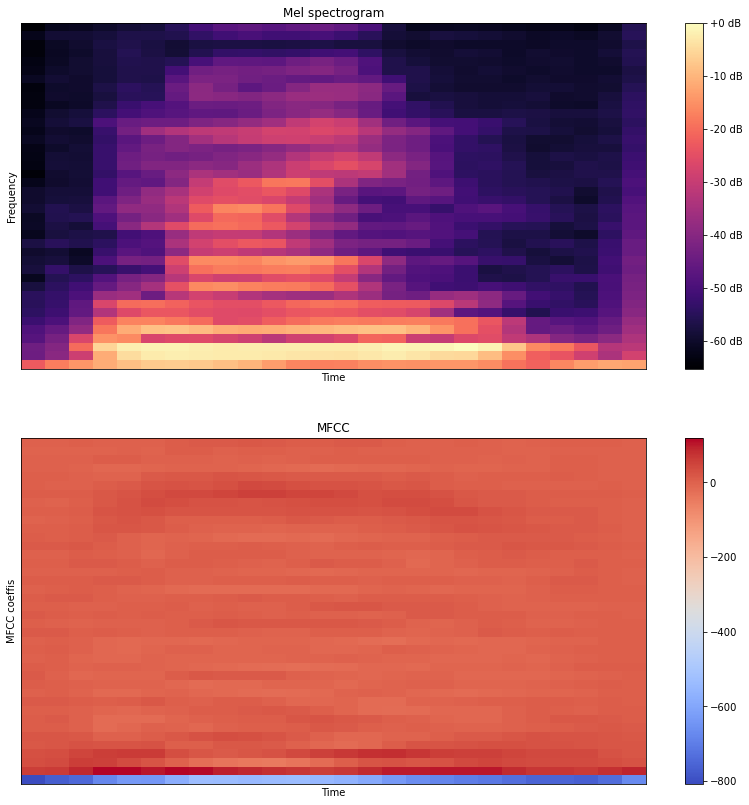

In [11]:
#1. melspectrogram
# 사람은 낮은 주파수를 높은 주파수보다 더 예민하게 받아들임.
# 500~1500Hz 가 바뀌는건 예민하게 인식하는데 반해 10000Hz~11000Hz가 바뀌는 것은 잘 인식 못한다는 것.
# 해당 scale을 적용해 spectogram을 만든 것이 melspectogram
# 주파수끼리 Correlate하기 때문에 도메인이 한정적인 문제에서 더 좋은 성능을 보임.

#2. mfcc
# Mel-Spectrogram이라는 피쳐에 대해 행렬을 압축해서 표현해주는 DCT 연산을 수행
# De-Correlate를 해주기 때문에 일반적인 상황에서 더 좋은 성능을 보여줌

#n_mels : 적용할 mel filter의 개수
size = 40
pad_size = 40

plt.figure(figsize=(14, 14))

ax = plt.subplot(2,1,1)
S = librosa.feature.melspectrogram(y=X_train[10], sr=sr, n_mels=size)
log_S = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(log_S, sr=sr)
plt.title('Mel spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(format='%+2.0f dB')

ax = plt.subplot(2,1,2)
mfcc = librosa.feature.mfcc(y=X_train[10], sr=sr, n_mfcc=size)
librosa.display.specshow(mfcc, sr=sr)
plt.title('MFCC')
plt.xlabel('Time')
plt.ylabel('MFCC coeffis')
plt.colorbar()

In [12]:
#오디오들의 길이가 같지 않기 때문에 melspectrogram과 mfcc 모두 길이가 제각각
# 1.여유로운 크기의 고정 사이즈를 정하고
# 2.고정사이즈에 맞추어 랜덤으로 앞이나 뒤에 padding을 실시
# 3.각각 파일마다 데시벨의 차이가 있을 것이라 생각하고 파일마다 min_max_scale 실시

def random_pad(mels, pad_size, mfcc=True):
    pad_width = pad_size - mels.shape[1]
    rand = np.random.rand()
    left = int(pad_width * rand)
    right = pad_width - left

    if mfcc:
        mels = np.pad(mels, pad_width=((0,0), (left,right)), mode='constant')
        local_max, local_min = mels.max(), mels.min()
        mels = (mels - local_min)/(local_max - local_min)
    else:
        local_max, local_min = mels.max(), mels.min()
        mels = (mels -local_min)/(local_max - local_min)
        mels = np.pad(mels, pad_width=((0,0), (left, right)), mode='constant')
    
    return mels

In [13]:
X_mels = []
X_mfcc = []

for y in tqdm(X_train, colour='yellow'):
    mels = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=size)
    mels = librosa.power_to_db(mels, ref=np.max)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=size)

    X_mels.append(random_pad(mels, pad_size=pad_size, mfcc=False))
    X_mfcc.append(random_pad(mfcc, pad_size=pad_size, mfcc=True))

X_mels[0]

100%|██████████| 5000/5000 [00:41<00:00, 120.46it/s]


array([[0.        , 0.        , 0.        , ..., 0.59285045, 0.5784485 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.44078305, 0.39646852,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.51043534, 0.45092484,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.10611606, 0.10445517,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.09051336, 0.07465776,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.05173246, 0.05366181,
        0.        ]], dtype=float32)

In [14]:
X_mels_test = []
X_mfcc_test = []

for y in tqdm(X_test, colour='red'):
    mels = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=size)
    mels = librosa.power_to_db(mels, ref=np.max)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=size)

    X_mels_test.append(random_pad(mels, pad_size=pad_size, mfcc=False))
    X_mfcc_test.append(random_pad(mfcc, pad_size=pad_size, mfcc=True))

X_mels_test[5]

100%|██████████| 1500/1500 [00:13<00:00, 114.78it/s]


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [15]:
#librosa로 리턴된값은 바로 모델에 들어갈 수 없기 때문에 np.array로 변환
X_mels = np.array(X_mels, np.float64)
X_mfcc = np.array(X_mfcc, np.float64)

X_mels_test = np.array(X_mels_test, np.float64)
X_mfcc_test = np.array(X_mfcc_test, np.float64)

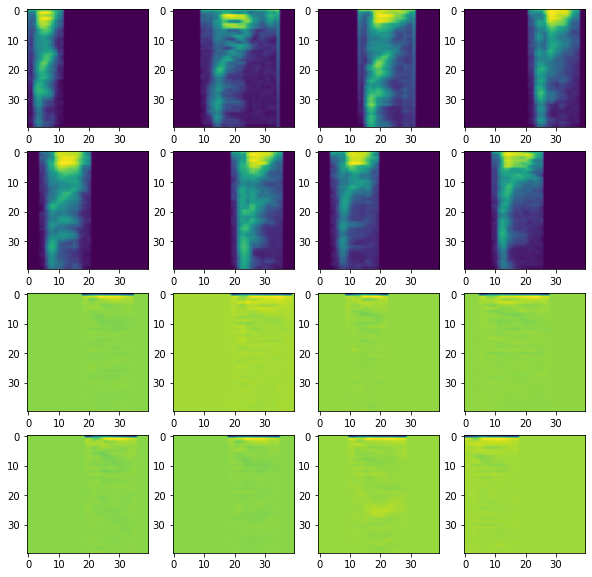

In [16]:
target_num = 2
target_num_idx = np.where(y_train == target_num)[0]
target_num_idx = np.random.choice(target_num_idx,16)

plt.figure(figsize=(10, 10))
ax = plt.subplot(4, 4, 1)

for i, idx in enumerate(target_num_idx):
    ax = plt.subplot(4, 4, i+1)
    if i<8:
        plt.imshow(X_mels[idx], aspect='auto')
    else:
        plt.imshow(X_mfcc[idx], aspect='auto')

In [17]:
print(X_mels.shape)
print(X_mfcc.shape)

(5000, 40, 40)
(5000, 40, 40)


In [18]:
#케라스에서 처리할 수 있는 형태로 변환 (샘플개수,가로,세로,차원)
X_mels = X_mels.reshape((5000,40,40,1))
X_mfcc = X_mfcc.reshape((5000,40,40,1))

In [19]:
print(X_mels.shape)
print(X_mfcc.shape)

(5000, 40, 40, 1)
(5000, 40, 40, 1)


In [20]:
from tensorflow.keras import utils

#원 핫 인코딩 처리
y_train = utils.to_categorical(y_train,10)
y_test = utils.to_categorical(y_test,10)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt

def make_model():
    model = Sequential()

    #convolution layer1
    #합성곱층, 필터수 50, 필터크기3x3, padding="same" 출력크기를 입력크기와 같게 유지
    model.add(Conv2D(32,(3,3), padding="same", input_shape=X_mels.shape[1:], activation='relu'))

    #convolution layer2,  맥스풀링, 2x2
    model.add(Conv2D(32,(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    #드롭아웃 과적합을 방지하기 위한 처리, 출력신호 25% off
    model.add(Dropout(0.25))

    #convolution layer3
    model.add(Conv2D(64,(3,3),padding="same",activation='relu'))

    #convolution layer4
    model.add(Conv2D(64,(3,3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())            #다차원 => 1차원 Data
    model.add(Dense(512,activation='relu'))

    #출력층
    model.add(Dense(10,activation='softmax'))

    #학습률 0.0001, decay 학습속도를 감소시키는 옵션 (학습을 얼마나 조밀하게 할것이냐)
    opt=optimizers.RMSprop(lr=0.0001, decay=1e-6)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model


In [22]:
#모델 생성
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 40, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 38, 38, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 19, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 19, 19, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 19, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 17, 17, 64)        36928     
                                                        

c:\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [23]:
#X_mfcc는 너무 오래걸리므로 구글 코랩에서 실행.
import tensorflow as tf
with tf.device('/CPU:0'):   #GPU로 돌리면 문제가 발생하므로 CPU로 돌린다.
    history = model.fit(X_mels,y_train,epochs=20,batch_size=32, validation_split=0.2)

Epoch 1/20
125/125 [==============================] - 17s 129ms/step - loss: 1.9795 - accuracy: 0.2975 - val_loss: 1.3473 - val_accuracy: 0.5250
Epoch 2/20
125/125 [==============================] - 16s 127ms/step - loss: 1.1165 - accuracy: 0.5990 - val_loss: 0.9232 - val_accuracy: 0.6880
Epoch 3/20
125/125 [==============================] - 16s 129ms/step - loss: 0.7807 - accuracy: 0.7193 - val_loss: 0.6557 - val_accuracy: 0.7670
Epoch 4/20
125/125 [==============================] - 16s 128ms/step - loss: 0.5871 - accuracy: 0.7908 - val_loss: 0.4771 - val_accuracy: 0.8420
Epoch 5/20
125/125 [==============================] - 16s 127ms/step - loss: 0.4508 - accuracy: 0.8422 - val_loss: 0.3596 - val_accuracy: 0.8920
Epoch 6/20
125/125 [==============================] - 16s 128ms/step - loss: 0.3665 - accuracy: 0.8750 - val_loss: 0.3038 - val_accuracy: 0.9100
Epoch 7/20
125/125 [==============================] - 16s 127ms/step - loss: 0.2992 - accuracy: 0.9010 - val_loss: 0.2461 - val_ac

In [25]:
X_mels_test = X_mels_test.reshape((1500,40,40,1))

with tf.device('/CPU:0'): 
    #검증용 데이터로 모델의 성능 평가 - mels
    test_loss, test_acc = model.evaluate(X_mels_test,y_test,batch_size=128)

12/12 [==============================] - 1s 75ms/step - loss: 0.1010 - accuracy: 0.9667


In [26]:
def plot_loss(history, title=None):
    #history dict 가 타입이 아니면
    if not isinstance(history, dict):
        history = history.history
    plt.plot(history["loss"])
    plt.plot(history["val_loss"])

    #타이틀이 설정되어 있지 않으면
    if title is not None:
        plt.title(title)
    plt.ylabel("손실") 
    plt.xlabel("에포크") 
    plt.legend(["학습 데이터 성능","검증 데이터 성능"], loc=0)  

def plot_acc(history, title=None):
    if not isinstance(history, dict):
        history = history.history
    plt.plot(history["accuracy"])
    plt.plot(history["val_accuracy"])
    if title is not None:
        plt.title(title)
    plt.ylabel("정확도") 
    plt.xlabel("에포크") 
    plt.legend(["학습 데이터 성능","검증 데이터 성능"], loc=0) 

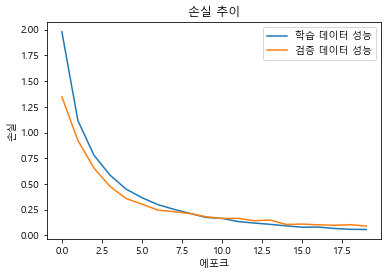

In [27]:
import matplotlib
import matplotlib.font_manager as fm
font_location = "c:/windows/fonts/malgun.ttf" 
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc("font", family=font_name)

plot_loss(history, '손실 추이')
plt.show()

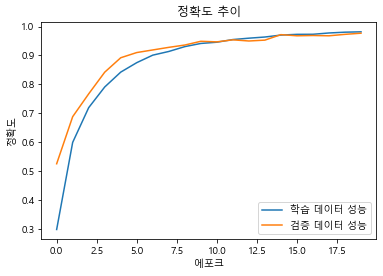

In [28]:
plot_acc(history, '정확도 추이') 
plt.show()

In [29]:
from sklearn.metrics import confusion_matrix
with tf.device('/CPU:0'):
    y_pred = model.predict(X_mels_test, verbose=1)
    
y_pred = np.argmax(y_pred, axis=1)
confusion_matrix(np.argmax(y_test,axis=1), y_pred)

47/47 [==============================] - 1s 26ms/step


array([[156,   0,   2,   2,   0,   0,   0,   1,   0,   1],
       [  1, 145,   0,   0,   0,   6,   0,   0,   0,   8],
       [  1,   0, 125,   2,   0,   0,   0,   0,   1,   0],
       [  0,   0,   1, 141,   0,   0,   0,   0,   2,   0],
       [  0,   1,   0,   0, 136,   1,   0,   0,   0,   0],
       [  0,   2,   0,   0,   0, 142,   0,   0,   0,   8],
       [  0,   0,   0,   0,   0,   0, 142,   0,   1,   0],
       [  1,   0,   0,   0,   0,   0,   0, 164,   0,   0],
       [  0,   0,   0,   3,   0,   0,   0,   0, 148,   0],
       [  1,   3,   0,   1,   0,   0,   0,   0,   0, 151]], dtype=int64)